In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import seaborn as sns
import statsmodels.api as sm

In [2]:
filename = "dfa.xlsx"

xl = pd.ExcelFile(filename)
sn = xl.sheet_names
sl = ",\n".join([f"{i} {s}" for i, s in enumerate(sn)])
print(f"Excel file <{filename}> has sheets:\n{sl}")

Excel file <dfa.xlsx> has sheets:
0 descriptions,
1 factors,
2 portfolios (total returns)


  Unnamed: 0            Name           Unit         Construction  \
0     Mkt-RF          Market  Excess Return  Market-cap-weighted   
1        SMB            Size  Excess Return      Small Minus Big   
2        HML           Value  Excess Return       High Minus Low   
3         RF  Risk-free rate   Total Return               Tbills   

                                         Description  
0                                        US Equities  
1             Long small stocks and short big stocks  
2  Long value (high book-to-market) stocks and sh...  
3                                                NaN  


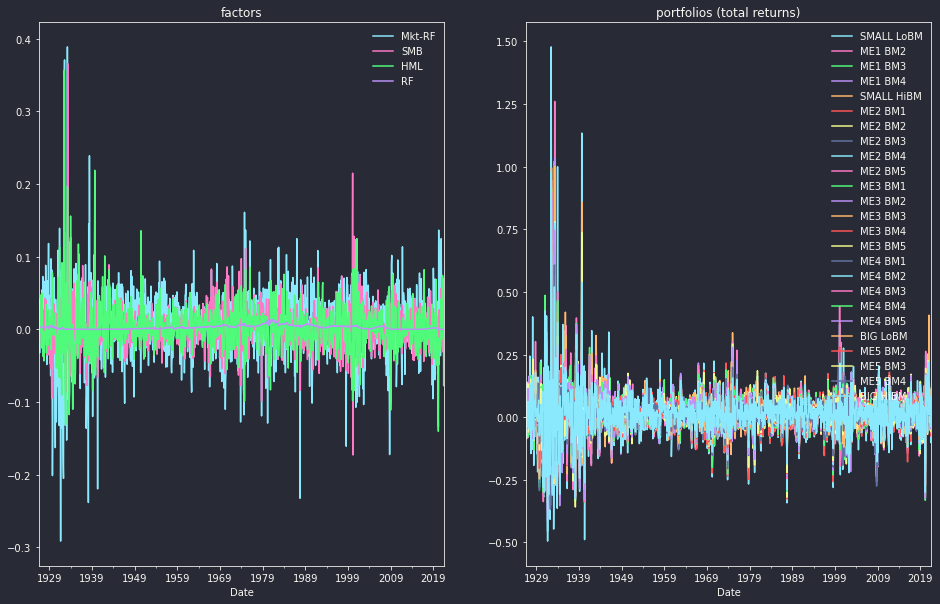

In [3]:
de = xl.parse(sn[0]) # de stands for Descriptions
print(de)
fa = xl.parse(sn[1]) # fa stands for Factors
fa.set_index("Date", inplace=True)
po = xl.parse(sn[2]) # po stands for Portfolios
po.set_index("Date", inplace=True)

fig, axs = plt.subplots(1,2)
fa.plot(ax=axs[0], title=f"{sn[1]}")
po.plot(ax=axs[1], title=f"{sn[2]}")
plt.show()

# 2. The Factors

#### 1. The Factors. Calculate their univariate performance statistics:

• mean

• volatility

• Sharpe

• VaR(.05)

Report these for the following three subsamples:

• Beginning - 1980

• 1981 - 2001

• 2002 - End

In [4]:
def pivot_summaries(data, year_mask, pi=0.05, nper=12):
    data_melt = pd.melt(data, ignore_index=False).sort_index()
    
    # Build Aggregation Functions here
    def me(x):
        return nper * np.mean(x)
    def sd(x): 
        return np.sqrt(nper) * np.std(x)
    def sr(x):
        return np.sqrt(nper) * np.mean(x) / np.std(x)
    def qt(x):
        return np.sqrt(nper) * np.quantile(x, pi)
    
    af = [me, sd, sr, qt]
    af_names = ["Mean", "Vol", "Sharpe", f"VaR({pi})"]
    
    pivlist = []
    for start, end in year_mask:
        piv = pd.pivot_table(data_melt[start:end], index="variable", values="value",
                             aggfunc=af)
        piv.columns = pd.MultiIndex.from_arrays([[f"{start}-{end}"] * len(af), af_names],
                                                names=["year", "measure"])
        pivlist.append(piv)

    summ = pd.concat(pivlist, axis=1)
    return summ

miny = str(min(fa.index).year)
maxy = str(max(fa.index).year)

year_mask = [(miny, "1980"), ("1981", "2001"), ("2002", maxy)]

summ = pivot_summaries(fa, year_mask)
summ

year     1926-1980                         1981-2001                           \
measure       Mean    Vol Sharpe VaR(0.05)      Mean    Vol  Sharpe VaR(0.05)   
variable                                                                        
HML         0.0491 0.1337 0.3674   -0.1486    0.0636 0.1110  0.5724   -0.1448   
Mkt-RF      0.0811 0.2049 0.3960   -0.2909    0.0773 0.1571  0.4918   -0.2236   
RF          0.0277 0.0077 3.6176    0.0000    0.0631 0.0077  8.1515    0.0085   
SMB         0.0340 0.1145 0.2967   -0.1505   -0.0005 0.1182 -0.0046   -0.1611   

year     2002-2021                           
measure       Mean    Vol  Sharpe VaR(0.05)  
variable                                     
HML        -0.0117 0.0973 -0.1204   -0.1385  
Mkt-RF      0.0947 0.1505  0.6292   -0.2676  
RF          0.0118 0.0042  2.7865    0.0000  
SMB         0.0238 0.0854  0.2792   -0.1296

#### 2. Based on the factor statistics above, answer the following.

(a) Does each factor have a premium (positive expected excess return) in each subsample?

(b) Does the premium to the size factor get smaller after 1980?

(c) Does the premium to the value factor get smaller during the 1990’s?

(d) How have the factors performed since the time of the case, (2002-present)?

pass

#### 3. The factors are constructed in such a way as to reduce correlation between them.

Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? Does it achieve this in each subsample?

pass

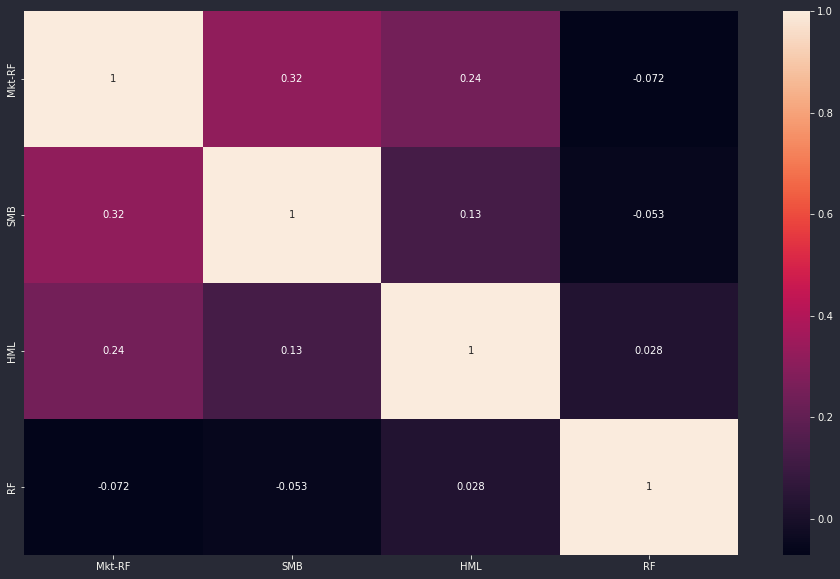

The pair with the HIGHEST correlation is ('Mkt-RF', 'SMB') at 0.31706024978982145
The pair with the LOWEST  correlation is ('Mkt-RF', 'RF') at -0.07152063259457404


In [5]:
def disp_corr(df):
    c = df.corr()
    sns.heatmap(c, annot=True); plt.show()
    
    cu = c.unstack().sort_values(ascending=False)
    cu = cu[c.shape[0]:] # There are c.shape[0] 1's in the corr matrix. Skip them.

    print(f"The pair with the HIGHEST correlation is {cu.idxmax()} at {cu.max()}")
    print(f"The pair with the LOWEST  correlation is {cu.idxmin()} at {cu.min()}")

disp_corr(fa)

#### 4. Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

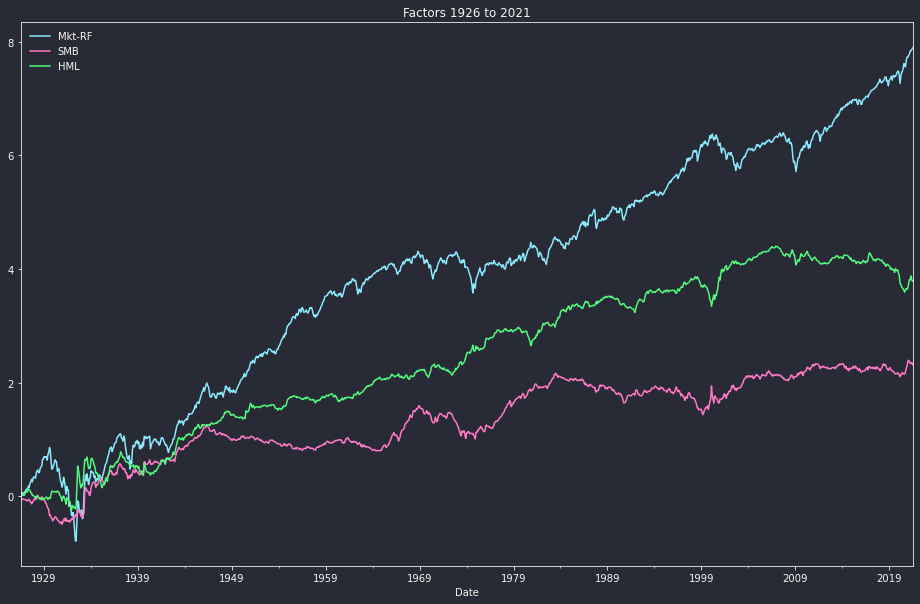

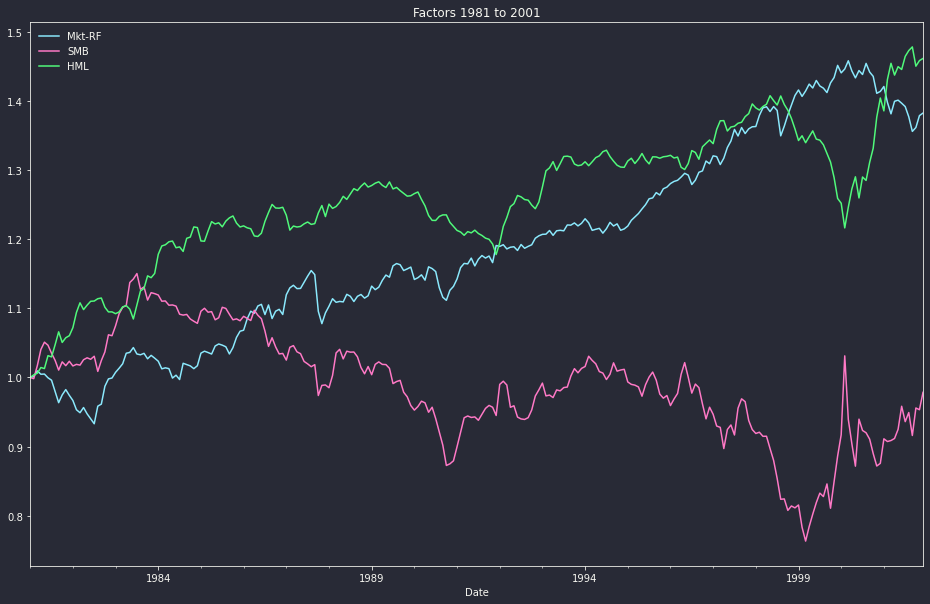

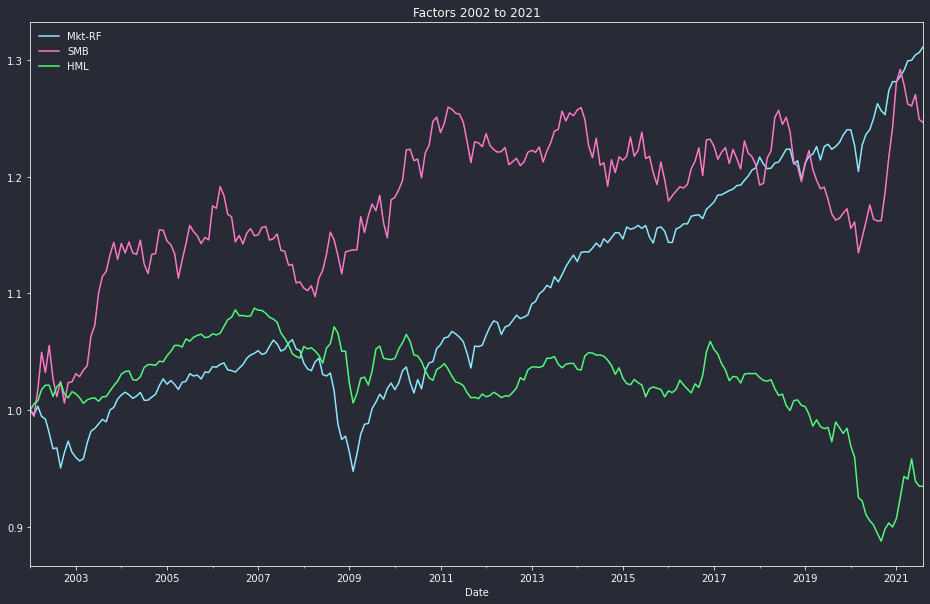

In [6]:
cr = fa.drop("RF", axis=1).cumsum()

cr.plot(title=f"Factors {miny} to {maxy}"); plt.show()

st = "1981"
ed = "2001"
temp = cr.loc[st:ed, :]
temp = temp / temp.iloc[0]
temp.plot(title=f"Factors {st} to {ed}"); plt.show()

st = "2002"
temp = cr.loc[st:maxy, :]
temp = temp / temp.iloc[0]
temp.plot(title=f"Factors {st} to {maxy}"); plt.show()

#### 5. Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

pass

# 3. CAPM

DFA believes that premia in stocks and stock portfolios is related to the three factors. Let’s test 25 equity portfolios that span a wide range of size and value measures.

• PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value characteristics. Denote these as ri, for n = 1, . . . , 25.

• Note that while the factors were given as excess returns, the portfolios are total returns.

• For this entire problem, focus on the 1981-Present subsample.

#### 1. Summary Statistics. For each portfolio,

• Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.

• Calculate the (annualized) univariate statistics from 1.1.

• Can the difference in mean excess returns of the portfolios be explained by differences in
their volatilities? Or by their VaR(.05) statistics?

pass

In [7]:
st = "1981"
po = po.subtract(fa["RF"], axis=0).loc[st:, :]

miny = str(min(po.index).year)
maxy = str(max(po.index).year)
posu = pivot_summaries(po, [("1981", "2001"), ("2002", maxy)])
posu

year       1981-2001                          2002-2021                \
measure         Mean    Vol  Sharpe VaR(0.05)      Mean    Vol Sharpe   
variable                                                                
BIG HiBM      0.1222 0.1681  0.7271   -0.2526    0.0752 0.2387 0.3148   
BIG LoBM      0.0837 0.1729  0.4843   -0.2608    0.1057 0.1454 0.7268   
ME1 BM2       0.0978 0.2504  0.3907   -0.3332    0.1165 0.2208 0.5277   
ME1 BM3       0.1023 0.1901  0.5382   -0.2294    0.0972 0.2046 0.4750   
ME1 BM4       0.1322 0.1806  0.7320   -0.2259    0.1169 0.2037 0.5742   
ME2 BM1       0.0240 0.2583  0.0930   -0.3786    0.1195 0.2259 0.5290   
ME2 BM2       0.0911 0.2029  0.4492   -0.2788    0.1291 0.2000 0.6456   
ME2 BM3       0.1017 0.1659  0.6130   -0.2095    0.1188 0.1976 0.6011   
ME2 BM4       0.1194 0.1566  0.7629   -0.1910    0.1018 0.2011 0.5064   
ME2 BM5       0.1285 0.1785  0.7200   -0.2384    0.1105 0.2424 0.4559   
ME3 BM1       0.0518 0.2428  0.2132   -0.3654    0.1116 0.2021 0.5521   
ME3 BM2       0.1014 0.1877  0.5404   -0.2539    0.1262 0.1855 0.6806   
ME3 BM3       0.0836 0.1580  0.5292   -0.2276    0.1092 0.1812 0.6026   
ME3 BM4       0.1104 0.1525  0.7240   -0.1892    0.1144 0.1987 0.5757   
ME3 BM5       0.1401 0.1638  0.8553   -0.2067    0.1134 0.2289 0.4957   
ME4 BM1       0.0784 0.2242  0.3497   -0.2914    0.1262 0.1754 0.7197   
ME4 BM2       0.0818 0.1749  0.4676   -0.2149    0.1197 0.1752 0.6830   
ME4 BM3       0.0924 0.1629  0.5675   -0.2207    0.0992 0.1836 0.5404   
ME4 BM4       0.1087 0.1501  0.7237   -0.1848    0.1004 0.1942 0.5171   
ME4 BM5       0.1284 0.1617  0.7946   -0.2124    0.0925 0.2281 0.4057   
ME5 BM2       0.0814 0.1651  0.4930   -0.2266    0.0973 0.1414 0.6886   
ME5 BM3       0.0747 0.1569  0.4765   -0.2377    0.0974 0.1470 0.6625   
ME5 BM4       0.0903 0.1552  0.5819   -0.2331    0.0416 0.1835 0.2266   
SMALL HiBM    0.1256 0.1746  0.7197   -0.2160    0.1436 0.2383 0.6023   
SMALL LoBM   -0.0246 0.2844 -0.0865   -0.4468    0.0721 0.2542 0.2836   

year                  
measure    VaR(0.05)  
variable              
BIG HiBM     -0.4194  
BIG LoBM     -0.2463  
ME1 BM2      -0.3212  
ME1 BM3      -0.2996  
ME1 BM4      -0.3153  
ME2 BM1      -0.3423  
ME2 BM2      -0.2894  
ME2 BM3      -0.2893  
ME2 BM4      -0.3205  
ME2 BM5      -0.3694  
ME3 BM1      -0.2671  
ME3 BM2      -0.2903  
ME3 BM3      -0.2850  
ME3 BM4      -0.3036  
ME3 BM5      -0.3382  
ME4 BM1      -0.2768  
ME4 BM2      -0.2941  
ME4 BM3      -0.2960  
ME4 BM4      -0.2842  
ME4 BM5      -0.3268  
ME5 BM2      -0.2261  
ME5 BM3      -0.2422  
ME5 BM4      -0.2698  
SMALL HiBM   -0.3429  
SMALL LoBM   -0.3895

#### 2. CAPM

The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio’s) expected excess return is completely a function of its beta to the equity market index (SPY, or in this case, MKT.)

Specifically, it asserts that, for any excess return, r ̃ , its mean is proportional to the mean excess mim
return of the market, r ̃ , where the proporitonality is the regression beta of r ̃ on r ̃ .
i i,m m
E[r ̃]=β E[r ̃ ] (CAPM) tt

Let’s examine whether that seems plausible.

(a) For each of the n = 25 test portfolios, run the CAPM time-series regression:
i i i,m m i r ̃ = α + β r ̃ + ε
ttt
So you are running 25 separate regressions, each using the T-sized sample of time-series data.

(b) Report the estimated βi,m, Treynor Ratio, αi, and Information Ratio for each of the n regressions.

(c) If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

Multifactor Treynor Ratio

Source: https://risk.edhec.edu/sites/risk/files/edhec-working-paper-the-generalised-treynor-ratio_1436274471613.pdf

In [23]:
def portstats_bm(v, bm, nper=12):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    bm: pd.DataFrame containing rows of returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, tr, ir = [], [], []
    beta = {}
    for col in bm.columns:
        beta[col] = []
    
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values)).fit()
        
        alpha.append(res.params[0])
        for i, col in enumerate(bm.columns):
            beta[col].append(res.params[i+1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() / np.sqrt(nper))
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.DataFrame(beta, index=c).T
    beta.index = ["beta_"+i for i in beta.index]
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha],
                       index=["mean", "std", "sharpe", "alpha"],
                       columns=c)
    end = pd.DataFrame([tr, ir], index=["treynor", "info ratio"], columns=c)
    
    ret = pd.concat([ret, beta, end])
    return ret

ps = portstats_bm(po.iloc[:, 0:3], fa.drop("RF", axis=1).loc[st:])
# list(ps.loc["beta", "SMALL LoBM"])
ps

,SMALL LoBM,ME1 BM2,ME1 BM3
mean,0.0222,0.1069,0.0998
std,0.2708,0.2368,0.1974
sharpe,0.0818,0.4513,0.5056
alpha,-0.0068,0.0007,0.0000
beta_Mkt-RF,1.1228,0.9776,0.9321
beta_SMB,1.3596,1.3258,1.0384
beta_HML,-0.2675,-0.0037,0.2971
treynor,0.0197,0.1093,0.1071
info ratio,-0.0766,0.0097,0.0004


#### 3. Cross-sectional Estimation

Let’s test (CAPM) directly. We already have what we need:

• The dependent variable, (y): mean excess returns from each of the n = 25 portfolios.

• The regressor, (x): the market beta from each of the n = 25 time-series regressions. Then we can estimate the following equation:

n×1 data regression intercept n×1 data regression estimate
i i,m
E[r ̃]= η +β; λm + υ

• Note that we use sample means as estimates of E[r ̃i].

• This is a weird regression! The regressors are the betas from the time-series regressions we
already ran!

• This is a single regression, where we are combining evidence across all n = 25 series. Thus, it is a cross-sectional regression!

• The notation is trying to emphasize that the intercept is different than the time-series α and that the regressor coefficient is different than the time-series betas.

(a) Report the R-squared of this regression.

(b) Report the intercept, η.

(c) Report the regression coefficient, λm.

What would these three statistics be if (CAPM) were true?

#### 4. Broadly speaking, do these results support DFA’s belief in size and value portfolios containing premia unrelated to the CAPM?